## Setup

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [265]:
import gc 

gc.collect()

0

In [312]:
import pandas as pd
import numpy as np 

from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression

import sdv.evaluation.single_table as sdv_eval
from sdv.single_table import (
    GaussianCopulaSynthesizer,
    CTGANSynthesizer, 
    TVAESynthesizer
)

In [267]:
pd.set_option("display.max_columns", None)

In [268]:
from src.utils import (
    load_config, 
    load_pickle, 
    get_clf_metrics, 
    display_clf_metrics, 
    make_sdv_metadata
)
from src.data import Data
from src.runner.scorenet_runner import ScoreNetRunner
from src.runner.anneal_runner import AnnealRunner

## Load original data

In [269]:
df = pd.read_csv("datasets/taiwan_payment.csv")

df.columns = df.columns.map(lambda col: col.replace(".", "_").lower())
df.drop(columns=["id"], inplace=True)

df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [270]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_bal                   30000 non-null  float64
 1   sex                         30000 non-null  int64  
 2   education                   30000 non-null  int64  
 3   marriage                    30000 non-null  int64  
 4   age                         30000 non-null  int64  
 5   pay_0                       30000 non-null  int64  
 6   pay_2                       30000 non-null  int64  
 7   pay_3                       30000 non-null  int64  
 8   pay_4                       30000 non-null  int64  
 9   pay_5                       30000 non-null  int64  
 10  pay_6                       30000 non-null  int64  
 11  bill_amt1                   30000 non-null  float64
 12  bill_amt2                   30000 non-null  float64
 13  bill_amt3                   300

In [271]:
df["default_payment_next_month"].value_counts(normalize=True, dropna=False)

0    0.7788
1    0.2212
Name: default_payment_next_month, dtype: float64

In [272]:
df_default = df[df["default_payment_next_month"] == 1]
df_default.drop(columns=["default_payment_next_month"], inplace=True)

Entries which have defaulted on their credit only account for 22% of the entire dataset. We thus focus the generative process on these samples. 

## Data preparation

In [432]:
CFG_TYPE = "scorenet"                           # "scorenet" or "anneal"
cfg = load_config(f"configs/{CFG_TYPE}.yaml") 

In [433]:
data = Data(cfg["data"])

data.preprocess(df)
data.make_loaders()

print(data) 

Data(target=default_payment_next_month, classification=True, reference=1, test_prop=0.2, batch_size=64, n_batches=375)


## Train/validate generator

In [434]:
if CFG_TYPE == "scorenet":
    runner = ScoreNetRunner(cfg, data)

elif CFG_TYPE == "anneal":
    runner = AnnealRunner(cfg, data) 

if cfg["mode"] == "train":
    loss_tracker = runner.train()

elif cfg["mode"] == "eval":
    loss_tracker = load_pickle(f"{cfg['backup']['dir']}/loss.pkl")

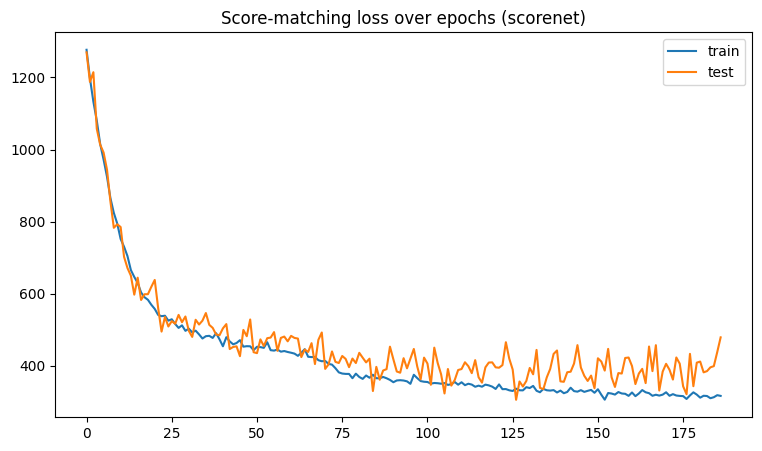

In [435]:
pd.DataFrame(loss_tracker).plot(figsize=(9, 5), title=f"Score-matching loss over epochs ({CFG_TYPE})"); 

## Generate new samples

In [431]:
synthetic_samples = runner.sample(n_batches=50)
synthetic_samples.shape

In [417]:
data.generate(synthetic_samples)

In [418]:
data.synthetic_df.head()

,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,sex,education,marriage
0,290076.375000,46.994648,0.484271,0.464069,0.784270,0.595142,0.241091,-0.125375,64432.468750,60276.984375,101099.945312,64671.535156,97700.726562,88405.718750,8960.564453,28364.914062,13954.478516,10796.647461,17086.501953,24552.677734,2.0,2.0,3.0
1,136496.468750,43.062962,0.270207,0.073559,0.900976,1.196478,0.597158,0.684854,104004.460938,77975.734375,62936.304688,48980.687500,63519.683594,61522.605469,20269.972656,26603.916016,16703.029297,14986.381836,4729.345215,8588.614258,2.0,6.0,2.0
2,230227.234375,39.407433,0.719261,0.793073,0.298324,-0.122042,0.106097,0.343490,72857.703125,45781.375000,45193.511719,108216.414062,71263.882812,49728.304688,22227.599609,19906.828125,22596.085938,18926.449219,5047.560059,15281.006836,2.0,4.0,1.0
3,251210.343750,43.358952,0.350231,0.392260,0.869657,0.560341,0.830657,0.187098,92575.757812,112009.531250,102162.625000,92422.242188,100185.945312,40215.460938,8096.756836,20882.322266,17505.089844,13006.456055,5639.644043,10635.344727,2.0,4.0,3.0
4,231776.828125,39.720207,0.128885,1.156578,0.605072,-0.349194,-0.095319,0.048993,106281.593750,64348.332031,70395.218750,100466.195312,103108.554688,37660.152344,12543.872070,22619.802734,8256.777344,12000.480469,4237.341309,12782.967773,2.0,6.0,2.0


## Evaluate synthetic data quality

In [419]:
metadata = make_sdv_metadata(data)

real_data = df_default.copy()
synthetic_data = data.synthetic_df.copy()

In [420]:
quality_report = sdv_eval.evaluate_quality(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:09<00:00,  2.49s/it]



Overall Quality Score: 52.12%

Properties:
Column Shapes: 39.49%
Column Pair Trends: 64.75%


In [408]:
column = "education"

fig = sdv_eval.get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_name=column,
    metadata=metadata)
        
fig.show()

## Classification models

With a view to assess the quality of the generated samples, we train 2 classifiers. The first one is trained on the original data whereas the second one is trained on the augmented dataset. Note the latter contains more default entries than the former due to data augmentation. 

In [388]:
target_names = ["No Default", "Default"]

clf = LogisticRegression(max_iter=1000)
clf.fit(data.X_tr, data.y_tr)

clf_report = get_clf_metrics(clf, data.X_tr, data.y_tr, data.X_te, data.y_te, target_names)

In [421]:
X_tr_aug = np.concatenate([data.X_tr, data.X_syn])
y_syn = np.ones(data.X_syn.shape[0])
y_tr_aug = np.concatenate([data.y_tr, y_syn])

clf_aug = LogisticRegression(max_iter=1000)
clf_aug.fit(X_tr_aug, y_tr_aug) 

clf_aug_report = get_clf_metrics(clf_aug, X_tr_aug, y_tr_aug, data.X_te, data.y_te, target_names)

In [422]:
display_clf_metrics(clf_report, clf_aug_report)

              Classification Report (train)              
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.819         │ 0.819          │
│ No Default recall    │ 0.972         │ 0.97           │
│ No Default f1-score  │ 0.889         │ 0.888          │
│ Default precision    │ 0.716         │ 0.933          │
│ Default recall       │ 0.245         │ 0.658          │
│ Default f1-score     │ 0.365         │ 0.771          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

              Classification Report (test)               
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.82          │ 0.821          │
│ No Default recall    │ 0.971         │ 0.97           │
│ No Default f1-score  │ 0.889         │ 0.889          │
│ Default precision    │ 0.698         │ 0.694          │
│ Default recall       │ 0.24          │ 0.245          │
│ Default f1-score     │ 0.357         │ 0.362          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

## Other generators

### Fit generators

In [313]:
generators = {
    "GaussianCopula": GaussianCopulaSynthesizer(metadata),
    "CTGAN": CTGANSynthesizer(metadata),
    "TVAE": TVAESynthesizer(metadata),
}

In [314]:
loop = tqdm(generators.items(), total=len(generators)) 

for key, generator in loop:
    loop.set_description(f"Fitting {key}...") 
    generator.fit(real_data)
    generators[key] = generator

# for key, generator in generators.items():
#     path = f"backup/taiwan_payment/sdv/{key}.pkl".lower()
#     generator.save(path)

  0%|          | 0/3 [00:00<?, ?it/s]

In [321]:
generator_names = ["GaussianCopula", "CTGAN", "TVAE"]

generators = {
    key: load_pickle(f"backup/taiwan_payment/sdv/{key}.pkl".lower())
    for key in generator_names
}

### Generate synthetic samples

In [322]:
n_samples = 5000

synthetic_datasets = {
    key: generator.sample(n_samples) for key, generator in generators.items()
}

In [339]:
feature_matrix_aug = {}

for key, ds in synthetic_datasets.items():
    x = data._preprocessor.transform(ds)
    feature_matrix_aug[key] = np.concatenate([data.X_tr, x])

target_aug = np.concatenate([data.y_tr, np.ones(n_samples)])

### Evaluate data quality 

In [335]:
quality_reports = {
    key: sdv_eval.evaluate_quality(
        real_data=real_data,
        synthetic_data=ds,
        metadata=metadata) 
    for key, ds in synthetic_datasets.items()
}

Creating report: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]



Overall Quality Score: 84.66%

Properties:
Column Shapes: 77.9%
Column Pair Trends: 91.43%


Creating report: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]



Overall Quality Score: 90.22%

Properties:
Column Shapes: 88.11%
Column Pair Trends: 92.34%


Creating report: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]



Overall Quality Score: 89.51%

Properties:
Column Shapes: 89.46%
Column Pair Trends: 89.56%


### Augmented classification models

In [340]:
clf_sdv = {
    key: LogisticRegression(max_iter=1000).fit(X_aug, target_aug) 
    for key, X_aug in feature_matrix_aug.items()
}

In [341]:
clf_sdv_report = {
    key: get_clf_metrics(clf, feature_matrix_aug[key], target_aug, data.X_te, data.y_te, target_names)
    for key, clf in clf_sdv.items()
}

In [362]:
for key, report in clf_sdv_report.items():
    title = f"Classification report for {key}"
    display_clf_metrics(clf_report, report, title=title)
    print("-"*70)

display_clf_metrics(clf_report, clf_aug_report, title=f"Classification report for {CFG_TYPE}")

    Classification report for GaussianCopula (train)     
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.819         │ 0.821          │
│ No Default recall    │ 0.972         │ 0.932          │
│ No Default f1-score  │ 0.889         │ 0.873          │
│ Default precision    │ 0.716         │ 0.836          │
│ Default recall       │ 0.245         │ 0.632          │
│ Default f1-score     │ 0.365         │ 0.72           │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

     Classification report for GaussianCopula (test)     
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.82          │ 0.823          │
│ No Default recall    │ 0.971         │ 0.931          │
│ No Default f1-score  │ 0.889         │ 0.873          │
│ Default precision    │ 0.698         │ 0.535          │
│ Default recall       │ 0.24          │ 0.285          │
│ Default f1-score     │ 0.357         │ 0.372          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

----------------------------------------------------------------------


         Classification report for CTGAN (train)         
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.819         │ 0.776          │
│ No Default recall    │ 0.972         │ 0.922          │
│ No Default f1-score  │ 0.889         │ 0.843          │
│ Default precision    │ 0.716         │ 0.786          │
│ Default recall       │ 0.245         │ 0.519          │
│ Default f1-score     │ 0.365         │ 0.625          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

         Classification report for CTGAN (test)          
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.82          │ 0.843          │
│ No Default recall    │ 0.971         │ 0.922          │
│ No Default f1-score  │ 0.889         │ 0.881          │
│ Default precision    │ 0.698         │ 0.581          │
│ Default recall       │ 0.24          │ 0.388          │
│ Default f1-score     │ 0.357         │ 0.465          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

----------------------------------------------------------------------


         Classification report for TVAE (train)          
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.819         │ 0.755          │
│ No Default recall    │ 0.972         │ 0.901          │
│ No Default f1-score  │ 0.889         │ 0.822          │
│ Default precision    │ 0.716         │ 0.724          │
│ Default recall       │ 0.245         │ 0.471          │
│ Default f1-score     │ 0.365         │ 0.571          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

          Classification report for TVAE (test)          
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.82          │ 0.842          │
│ No Default recall    │ 0.971         │ 0.901          │
│ No Default f1-score  │ 0.889         │ 0.87           │
│ Default precision    │ 0.698         │ 0.528          │
│ Default recall       │ 0.24          │ 0.396          │
│ Default f1-score     │ 0.357         │ 0.453          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

----------------------------------------------------------------------


       Classification report for scorenet (train)        
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.819         │ 0.816          │
│ No Default recall    │ 0.972         │ 0.964          │
│ No Default f1-score  │ 0.889         │ 0.884          │
│ Default precision    │ 0.716         │ 0.919          │
│ Default recall       │ 0.245         │ 0.655          │
│ Default f1-score     │ 0.365         │ 0.765          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘

        Classification report for scorenet (test)        
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric               ┃ Original Data ┃ Augmented Data ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ No Default precision │ 0.82          │ 0.825          │
│ No Default recall    │ 0.971         │ 0.964          │
│ No Default f1-score  │ 0.889         │ 0.889          │
│ Default precision    │ 0.698         │ 0.676          │
│ Default recall       │ 0.24          │ 0.268          │
│ Default f1-score     │ 0.357         │ 0.384          │
│ accuracy             │ 0.811         │ 0.811          │
└──────────────────────┴───────────────┴────────────────┘